<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

***Цели исследования:***

1. Загрузить и подготовить данные.
2. Обучите разные модели и выбрать лучшую.
3. Подобрать гиперпараметры для лучшей модели.

***Ход исследования***

Входные данные от заказчика — исторические данные о заказах такси в аэропортах предоставлены в файле taxi.csv. Перед обучением моделей необходимо провести предобработку данных. После подготовить данные для обучения, обучить модели и сравнить результаты метрикой RMSE. Подобрать гиперпараметры лучшей модели.

## Подготовка

Импортируем библиотеки:

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import time

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [23]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except Exception:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Получим общую информацию о данных.

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Можем немного уменьшить размер данных приведя все значения столбца 'num_orders' к int32.

In [25]:
df['num_orders'] = df['num_orders'].astype('int32')

Проведим данные на наличие пропусков.

In [26]:
df.isna().sum()

num_orders    0
dtype: int64

Проверим в хронологическом ли порядке расположены даты и время.

In [27]:
df.index.is_monotonic

True

Нам дана выборка данных за пол года, с марта по август 2018. Данные загружены и проверены перед анализом.

## Анализ

Построим график по имеющимся данным.

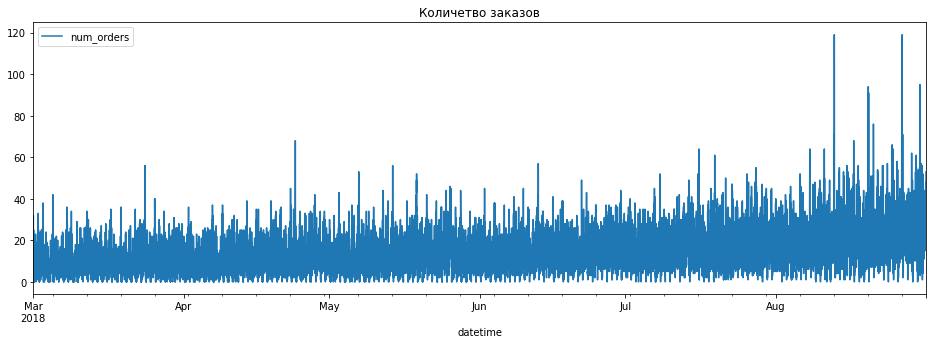

In [28]:
df.plot(title='Количетво заказов', figsize=(16, 5));

Из-за того что данные даны с интервалом в 10 минут график получается неразборчивым. Возьмём новый интервал — 1 час. Данные за час просуммируем.

In [29]:
df_hour = df.resample('1H').sum()

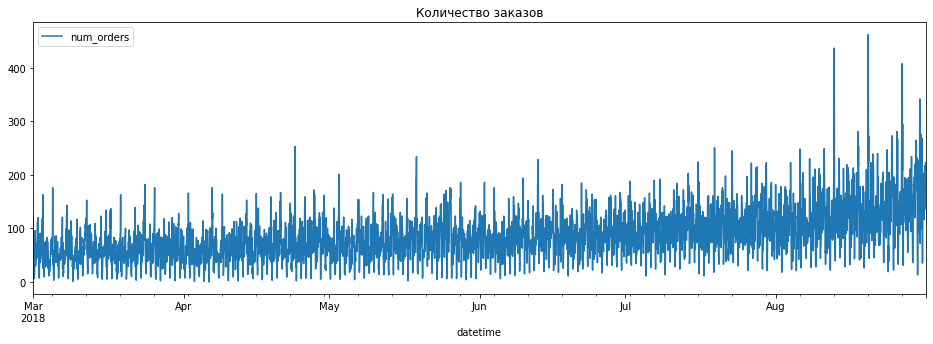

In [30]:
df_hour.plot(title='Количество заказов', figsize=(16, 5));

Визуализируем тренды и сезонность.

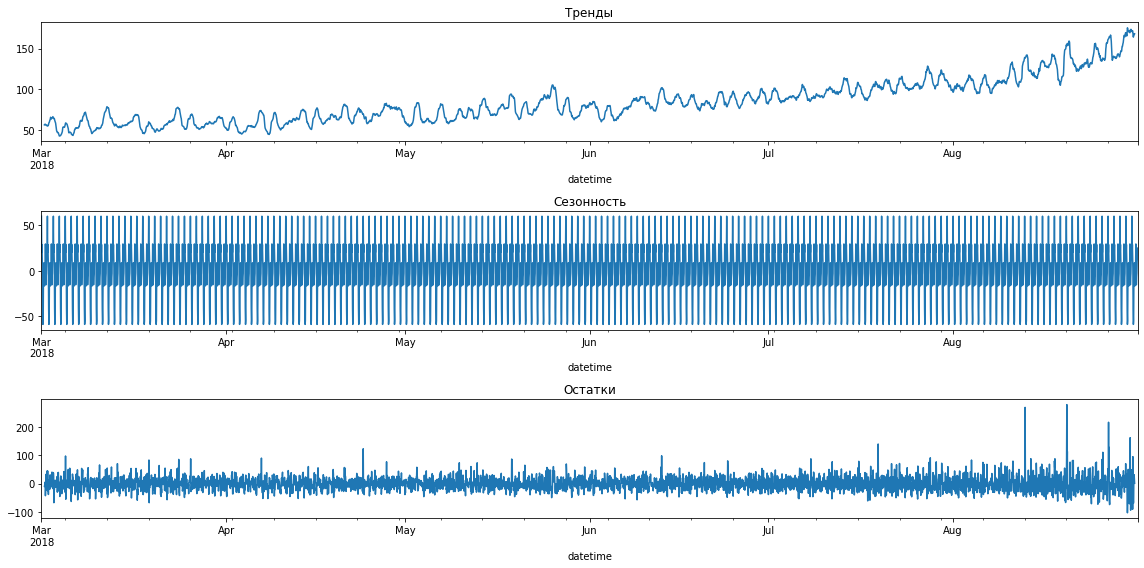

In [31]:
decomposed = seasonal_decompose(df_hour)

plt.figure(figsize=(16, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренды')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Остатки')
plt.tight_layout()

На первом графике отчётливо видно восходящий тренд числа заказов в течении года. Так же на этом графике можно заметить повторяюзиеся пики и спады заказов в течении недели. Построим график для одного месяца.

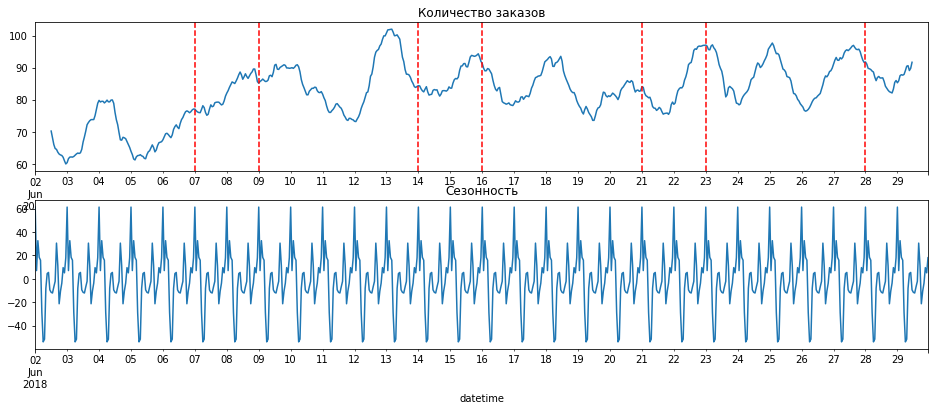

In [32]:
# Сделаем срез за 4 полные недели июля.
df_july = df_hour['2018-06-02':'2018-06-29']

decomposed_july = seasonal_decompose(df_july)

plt.figure(figsize=(16, 6))

plt.subplot(211)
decomposed_july.trend.plot(ax=plt.gca())
plt.title('Количество заказов')
plt.axvline(x='2018-06-07', linestyle = '--', color='r')
plt.axvline(x='2018-06-09', linestyle = '--', color='r')
plt.axvline(x='2018-06-14', linestyle = '--', color='r')
plt.axvline(x='2018-06-16', linestyle = '--', color='r')
plt.axvline(x='2018-06-21', linestyle = '--', color='r')
plt.axvline(x='2018-06-23', linestyle = '--', color='r')
plt.axvline(x='2018-06-28', linestyle = '--', color='r')

plt.subplot(212)
decomposed_july.seasonal.plot(ax=plt.gca())
plt.title('Сезонность');

Для наглядности выходные на графике выделены пунктирными линиями. В течении месяца заметны хаотичные всплески заказов. Так же видео общий восходящий тренд. Заметна характерная сезонность.

## Обучение

Напишем функцию для создания дополнительных признаков.

In [33]:
def make_features(data, max_lag, rolling_mean_size):
    
    df_temp = data.copy()
    df_temp['dayofweek'] = data.index.dayofweek
    df_temp['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        df_temp[f'lag_{lag}'] = df_temp['num_orders'].shift(lag)

    df_temp['rolling_mean'] = df_temp['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df_temp
    
df_new_feat = make_features(df_hour, 1, 24) # 24-часа

Разобъём данные на тренировочную и тестовую выборки.

In [34]:
train, test = train_test_split(df_new_feat, shuffle=False, test_size=0.1)
train = train.dropna()
test = test.dropna()

X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

После того как данные подготовлены переходим к определению лучшей модели. Для сравнения возьмём простую модель логистической регрессии и две модели градиентного спуска. Обучим их и сравним метрики RMSE.

In [35]:
result = pd.DataFrame(columns=['Time_to_learn', 'Time_to_prediction', 'RMSE'])

def model_check(model_name, model): # Функция принимает на вход модель и записывает результат в таблицу.

    start_learn = time.time()
    model.fit(X_train, y_train)
    end_learn = time.time()
    
    start_prediction = time.time()
    predict = model.predict(X_test)
    end_prediction = time.time()
    
    result.loc[model_name] = [
        end_learn - start_learn,
        end_prediction - start_prediction,
        round(mean_squared_error(y_test, predict, squared=False), 2)]
    
    return result.sort_values('RMSE')
    
# LinearRegression()
model_check('LogisticRegression', LogisticRegression())

# CatBoostRegressor()
model_check('CatBoost', CatBoostRegressor(silent=True, random_state=12345))

# LGBMRegressor()
model_check('LightGBM', LGBMRegressor(random_state=12345))



/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Time_to_learn,Time_to_prediction,RMSE
LightGBM,4.098900,0.091993,43.39
CatBoost,1.888362,0.001994,43.70
LogisticRegression,19.660149,0.002634,72.36


Лучший результат показала модель LightGBM. Попробуем подобрать гиперпараметры и улучшить результаты.

In [38]:
%%time

model = LGBMRegressor(random_state=12345)

dict_param = dict(n_estimators = range(1, 120, 10), max_depth = range(1, 10))

lgbm_grid = GridSearchCV(
    model, 
    dict_param, 
    cv=TimeSeriesSplit(),
    scoring='neg_mean_squared_error')

lgbm_grid.fit(X_train, y_train)

predict = lgbm_grid.predict(X_test)

print('RMSE:', round(mean_squared_error(y_test, predict, squared=False), 2))

RMSE: 43.1
CPU times: user 5min 4s, sys: 3.02 s, total: 5min 7s
Wall time: 5min 9s


В результате подбора гиперпараметров удалось незначительно улучшить качество модели (на 1%).

## Тестирование

Отразим на графике фактические заказы и предсказанные моделью.

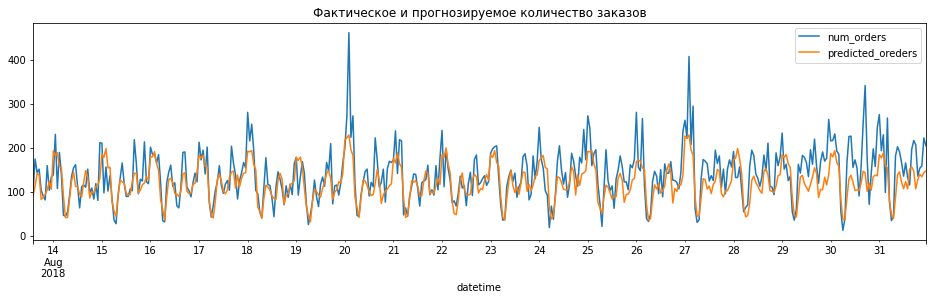

In [39]:
compare = pd.DataFrame(y_test)
compare['predicted_oreders'] = predict
compare.plot(title='Фактическое и прогнозируемое количество заказов', figsize=(16, 4));

Видно, что в целом модель делает предсказания близкие к реальным данным, но пропускает резкие "всплески".

## Вывод 

Изначально были даны исторические данные о заказах такси в аэропортах и поставлена задача спрогнозировать количество заказов такси на следующий час. Данные были даны в подготовленном виде. При анализе данных увидели что есть тредн на увеличение заказов. Сравнив результаты трёх моделей, выбрали лучшую и подобрали гиперпараметры, что позволило повысить качество предсказания модели. Отобразили на графике реальные и предсказанные данные в результате чего наглядно убедились в том что модель прогнозирует значения близкие к реальным.